# MCMC sampling diagnostics

In this notebook, we illustrate how to assess the quality of your MCMC samples, e.g. convergence and auto-correlation, in pyPESTO.

## The pipeline

First, we load the model and data to generate the MCMC samples from. In this example we show a toy example of a conversion reaction, loaded as a [PEtab](https://github.com/petab-dev/petab) problem.

In [1]:
import pypesto
import petab
import numpy as np

# import to petab
petab_problem = petab.Problem.from_yaml(
    "conversion_reaction/conversion_reaction.yaml")
# import to pypesto
importer = pypesto.PetabImporter(petab_problem)
# create problem
problem = importer.create_problem()

Create the sampler object, in this case we will use adaptive parallel tempering with 3 temperatures.

In [2]:
sampler = pypesto.AdaptiveParallelTemperingSampler(
    internal_sampler=pypesto.AdaptiveMetropolisSampler(),
    n_chains=3)

First, we will initiate the MCMC chain at a "random" point in parameter space, e.g. $\theta_{start} = [3, -4]$

In [3]:
result = pypesto.sample(problem, n_samples=10000, sampler=sampler, x0=np.array([3,-4]))

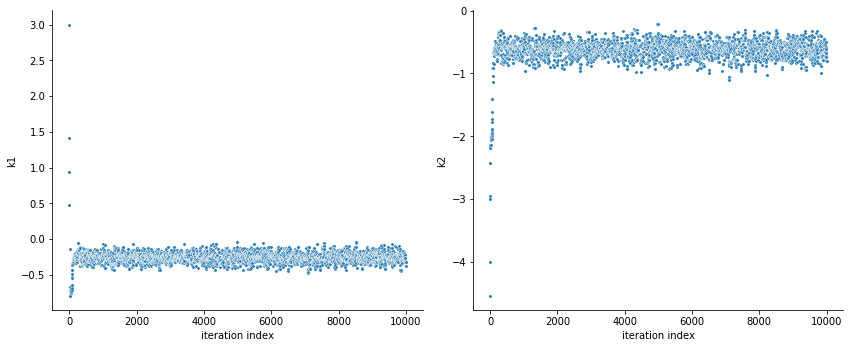

In [4]:
ax = pypesto.visualize.sampling_parameters_trace(result, use_problem_bounds=False, size=(12,5))

By visualizing the chains, we can see a warm up phase occurring until convergence of the chain is reached. This is commonly known as "burn in" phase and should be discarded. An automatic way to evaluate and find the index of the chain in which the warm up is finished can be done by using the Geweke test.

Geweke Burn-in index: 500


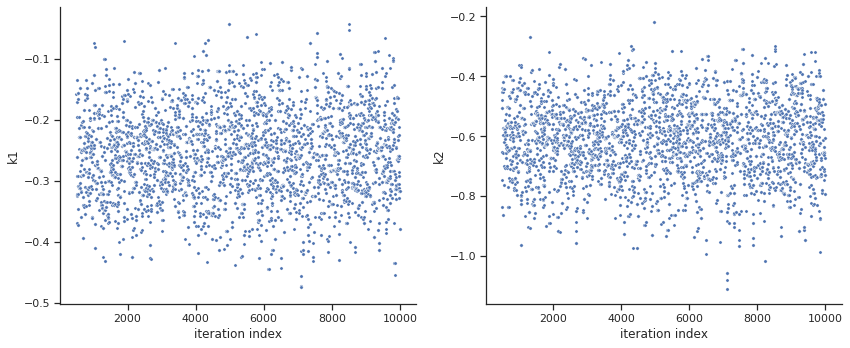

In [5]:
result = pypesto.sampling.geweke_test(result=result)
ax = pypesto.visualize.sampling_parameters_trace(result, use_problem_bounds=False, size=(12,5))

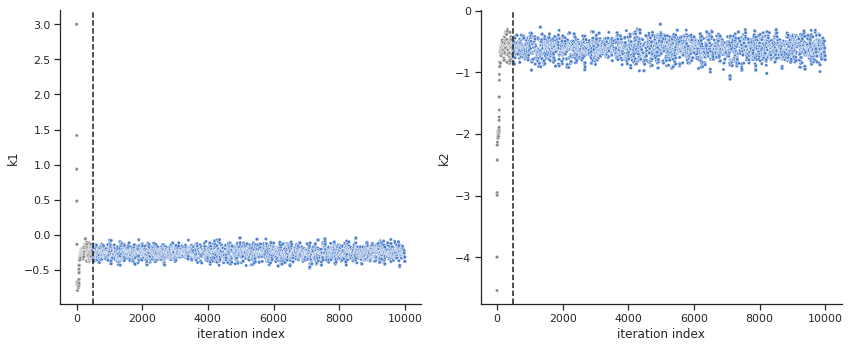

In [6]:
ax = pypesto.visualize.sampling_parameters_trace(result, use_problem_bounds=False, full_trace=True, size=(12,5))

In [7]:
ess = pypesto.sampling.effective_sample_size(result=result)
elapsed_time = result.sample_result['elapsed_time']
print('Effective sample size: '+str(ess))
print('Effective sample size per time: '+str(ess/elapsed_time))

Effective sample size: 1032.2960473169753
Effective sample size per time: 25.665230000949684


Commonly, as a first step, optimization is performed, in order to find good parameter point estimates.

In [8]:
res = pypesto.minimize(problem, n_starts=10)

Function values from history and optimizer do not match: 2396.349431362471, 2632.872888190236
Parameters obtained from history and optimizer do not match: [ 1.63506243 -1.29982009], [-11.17768313  11.51292546]


By passing the result object to the function, the previously found global optimum is used as starting point for the MCMC sampling.

In [9]:
res = pypesto.sample(problem, n_samples=10000, sampler=sampler, result=res)

When the sampling is finished, we can analyse our results. pyPESTO provides functions to analyse both the sampling process as well as the obtained sampling result. Visualizing the traces e.g. allows to detect burn-in phases, or fine-tune hyperparameters. First, the parameter trajectories  can be visualized:

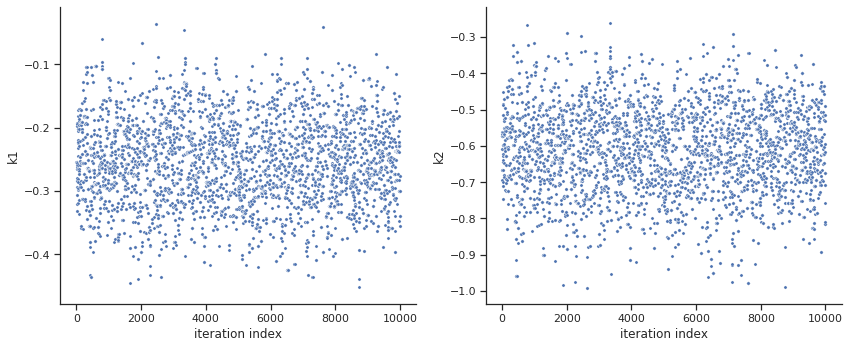

In [10]:
ax = pypesto.visualize.sampling_parameters_trace(res, use_problem_bounds=False, size=(12,5))

By visual inspection one can see that the chain is already converged from the start. This is already showing the benefit of initiating the chain at the optimal parameter vector. However, this may not be always the case.

Geweke Burn-in index: 0


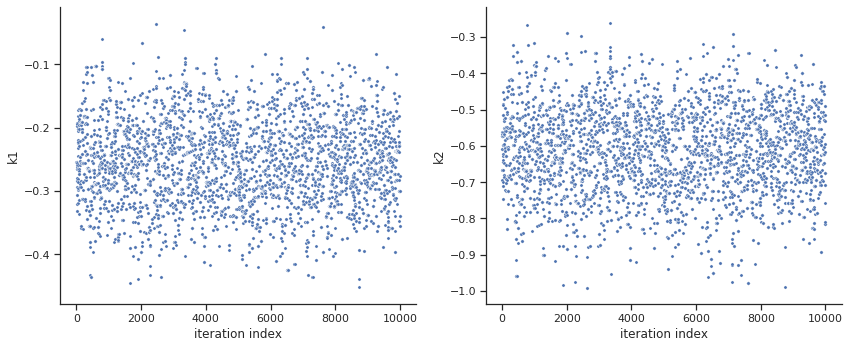

In [11]:
burn_in = pypesto.sampling.geweke_test(result=res)
ax = pypesto.visualize.sampling_parameters_trace(res, use_problem_bounds=False, size=(12,5))

In [12]:
ess = pypesto.sampling.effective_sample_size(result=res)
elapsed_time = res.sample_result['elapsed_time']
print('Effective sample size: '+str(ess))
print('Effective sample size per time: '+str(ess/elapsed_time))

Effective sample size: 1139.3721078864332
Effective sample size per time: 28.003801258509032
